In [ ]:
# load data
import json
import pandas as pd
import os

coco_path = '../dataset/coco'
data_file = f'../dataset/coco/coco-cn-version1805v1.1/imageid.human-written-caption.txt'

df = pd.read_table(data_file, sep='\t', header=None, names = ['file_name', 'caption'])


In [ ]:
df['file_name'] = df['file_name'].apply(lambda x: os.path.join(x.split('_')[1], x.split('#')[0]+'.jpg'))

In [ ]:
# shuffle the dataset
df = df.sample(frac=1)


# remove duplicate images
df = df.drop_duplicates(subset='file_name')


# create a random subset
n_samples = 1000
df_sample = df.sample(n_samples)
# save the sample to a parquet file
df_sample.to_parquet(f'{coco_path}/subset_cn.parquet')


# copy the images to reference folder
from pathlib import Path
import shutil
subset_path = Path(f'{coco_path}/subset_cn')
subset_path.mkdir(exist_ok=True)
for i, row in df_sample.iterrows():
    path = f'{coco_path}/' + row['file_name']
    shutil.copy(path, f'{coco_path}/subset_cn/')

In [ ]:
# center crop the images
def center_crop_images(folder, output_folder, size):
    # coco images are not square, so we need to center crop them
    from PIL import Image
    import os
    os.makedirs(output_folder, exist_ok=True)
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = Image.open(image_path)
        width, height = image.size
        left = (width - size) / 2 if width > size else 0
        top = (height - size) / 2 if height > size else 0
        right = (width + size) / 2 if width > size else width
        bottom = (height + size) / 2 if height > size else height
        image = image.crop((left, top, right, bottom))
        image = image.resize((size, size))  # resize non-square images
        image.save(os.path.join(output_folder, file))

folder_name = '../dataset/coco/subset_cn'
output_folder = '../dataset/coco/subset_cn_cropped'
center_crop_images(folder_name, output_folder, 320)

# ⬆️ preprocess data ⬇️ load data

In [1]:
# load the subset
from torch.utils.data import Dataset, DataLoader
import pandas as pd 

class COCOCaptionSubset(Dataset):
    def __init__(self, path, transform=None):
        self.df = pd.read_parquet(path)
        self.df['file_name'] = self.df['file_name'].apply(lambda x: x.replace('/', '_'))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        return row['file_name'], row['caption']

# testing 
coco_path = '../dataset/coco'
coco_cache_file = f'{coco_path}/subset_cn.parquet'     # sampled subsets
cocosubset = COCOCaptionSubset(coco_cache_file)
cocosubsetloader = DataLoader(cocosubset, batch_size=16, shuffle=False, num_workers=8)


In [ ]:
cocosubset[0]

In [ ]:
from diffusers import StableDiffusionPipeline, DDIMScheduler
stable_diffusion = StableDiffusionPipeline.from_pretrained("../pretrained_models/stable_cn").to('cuda')   
out = stable_diffusion('古道西风瘦马，中国画')
out[0][0]

# After generation by `run_generator_cn.sh`

In [1]:
# fid
import torch
device = torch.device('cuda')

coco_subset_crop_path = '../dataset/coco/subset_cn_cropped'
output_root = './output_cn'
output_paths = [os.path.join(output_root, out) for out in sorted(os.listdir(output_root))]


from pytorch_fid.fid_score import calculate_fid_given_paths

fids = []
for output_path in output_paths:
    fid_value = calculate_fid_given_paths([coco_subset_crop_path, output_path], batch_size=200, device=device, dims=2048, num_workers=8)
    fids.append(fid_value)
    print(output_path, fid_value)

/home/tiger/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tiger/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


[0.37982094 0.32691598 0.32423221 ... 0.46967193 0.41200255 0.40518777] (2048,)
./output_cn/gs1.5_ss20 82.83122165497986


  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [3]:
# clip score
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, BertTokenizer, BertModel
from PIL import Image
import numpy as np
from tqdm import tqdm

def load_clip_model(model_path='openai/clip-vit-large-patch14'):
    text_encoder = BertModel.from_pretrained('../pretrained_models/Taiyi-CLIP-RoBERTa-102M-ViT-L-Chinese').eval().cuda()
    text_tokenizer = BertTokenizer.from_pretrained('../pretrained_models/Taiyi-CLIP-RoBERTa-102M-ViT-L-Chinese')
    clip_model = CLIPModel.from_pretrained(model_path)
    processor = CLIPProcessor.from_pretrained(model_path)
    # tokenizer = CLIPTokenizer.from_pretrained(model_path)

    clip_model = clip_model.eval().cuda()
    return clip_model, processor, text_tokenizer, text_encoder


def clip_score(clip_model, processor, tokenizer, text_encoder, dataloader, output_image_path):
    all_image_features = []
    all_text_features = []
    for (i, (image_paths, captions)) in enumerate(tqdm(dataloader)):
        # print(image_paths, captions)
        text_inputs = tokenizer(list(captions), padding=True, return_tensors="pt").to('cuda')
        # print(text_inputs)
        text_features = text_encoder(text_inputs.input_ids)[1]
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.detach().cpu().numpy()
        all_text_features.append(text_features)

        images = [Image.open(os.path.join( output_image_path , image_path)) for image_path in image_paths]
        image_inputs = processor(images = images, return_tensors="pt").to('cuda')
        image_features = clip_model.get_image_features(**image_inputs)
        # image_inputs = [processor(image) for image in images]
        # image_inputs = torch.stack(image_inputs).to('cuda')
        image_features = clip_model.get_image_features(**image_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.detach().cpu().numpy()
        all_image_features.append(image_features)

    all_text_features = np.concatenate(all_text_features, axis=0)
    all_image_features = np.concatenate(all_image_features, axis=0)
    mean_similarity = (all_image_features @ all_text_features.T).diagonal().mean()
    return mean_similarity


clip_model_path="../pretrained_models/clip-vit-large-patch14"
clip_model, processor, tokenizer, text_encoder = load_clip_model(clip_model_path)
clip_scores = []
for output_path in output_paths:
    clip_score_each = clip_score(clip_model, processor, tokenizer, text_encoder, cocosubsetloader, output_path)   
    print(output_path, clip_score_each)
    clip_scores.append(clip_score_each)

100%|██████████| 63/63 [00:31<00:00,  1.98it/s]


./output_cn/gs1.5_ss20 0.10783037


100%|██████████| 63/63 [00:31<00:00,  2.00it/s]


./output_cn/gs2.0_ss20 0.12101555


100%|██████████| 63/63 [00:31<00:00,  2.00it/s]


./output_cn/gs3.0_ss20 0.13520376


100%|██████████| 63/63 [00:31<00:00,  2.01it/s]


./output_cn/gs4.0_ss20 0.14092724


100%|██████████| 63/63 [00:31<00:00,  1.99it/s]


./output_cn/gs5.0_ss20 0.14418064


100%|██████████| 63/63 [00:31<00:00,  1.99it/s]


./output_cn/gs6.0_ss20 0.1452085


100%|██████████| 63/63 [00:31<00:00,  2.00it/s]


./output_cn/gs7.0_ss20 0.1480369


100%|██████████| 63/63 [00:31<00:00,  2.00it/s]

./output_cn/gs8.0_ss20 0.14733191


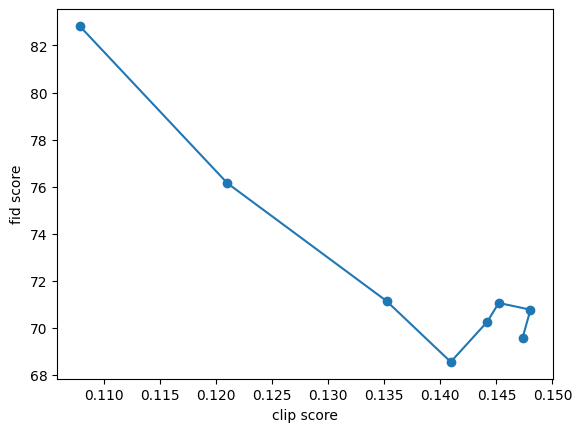

In [4]:
# plot clip score as x-axis, fid score as y-axis, line chart
import matplotlib.pyplot as plt
plt.plot(clip_scores, fids, 'o-')
plt.xlabel('clip score')
plt.ylabel('fid score')
plt.show()